## Discover the genetic basis of poplar tree adaptation to climate zones

We'll use genetics data along with climate data to discover the genetic basis of climate adaptation in poplar trees. This knowledge is essential to engineer trees to grow in non-native climate regimes -- to enable the cultivation of marginal lands and increase the reach of forests around the world. Poplar trees are also an important biofuel feedstock, their woody biomass is used in fermentation bioreactors to produce biofuels and other bio-products, including industrial chemicals, cosmetics, and consumer products. 

In [1]:
import pandas as pd
import numpy as np
from os.path import join as oj
import datatable as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline # 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer #compute NAs
from sklearn.metrics import r2_score, mean_squared_error #r-squared
import copy

In [2]:
from numpy import isnan
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
import seaborn as sns

### 1. Load in data

#### SNP data

In [3]:
snp_orig_dt = dt.fread("869_NoCal_CR0.99.tagSNPs_BigLD0.70.txt", fill=True)

In [4]:
snp_orig_dt.shape


(869, 786075)

In [5]:
snp_orig_dt[:, :10].head()


,FID,IID,PAT,MAT,SEX,PHENOTYPE,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A
,▪▪▪▪,▪▪▪▪,▪,▪,▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,BESC-418,BESC-418,0,0,0,−9,1,2,2,2
1,BESC-52,BESC-52,0,0,0,−9,2,1,2,2
2,BESC-79,BESC-79,0,0,0,−9,2,1,NA,2
3,BESC-246,BESC-246,0,0,0,−9,NA,NA,2,2
4,BESC-313,BESC-313,0,0,0,−9,2,1,2,1
5,BESC-460,BESC-460,0,0,0,−9,2,0,2,2
6,GW-10958,GW-10958,0,0,0,−9,2,1,2,2
7,DENA-17-3,DENA-17-3,0,0,0,−9,2,0,2,2
8,VNDL-27-4,VNDL-27-4,0,0,0,−9,2,0,2,2


#### Response data

In [6]:
cloud_dens_orig = pd.read_csv(oj("cloud_dens_yearAvg"), sep="\t", header=None)
tmin_orig = pd.read_csv(oj("tmin_yearAvg"), sep="\t", header=None) 

## 2. Basic Data Cleaning

In [7]:
na_col_counts = snp_orig_dt.countna()  # get number of NAs per column
pd.DataFrame(na_col_counts.to_numpy().T).describe()

,0
count,786075.000000
mean,1.650722
std,2.205017
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,8.000000


In [8]:
na_row_counts = snp_orig_dt[:, dt.dt.rowcount(dt.f[:])]  # get number of NAs per row
snp_orig_dt.shape[1] - na_row_counts.min().to_numpy()  # max number of NAs in a row


array([[53860]], dtype=int32)

In [9]:
snp_orig = snp_orig_dt.to_pandas()

In [10]:
#check if it has duplicate value
len(snp_orig['FID'].unique()) == len(snp_orig['FID'])

True

In [11]:
#drop the first 6 column which are not variable
X = snp_orig.drop(columns=["FID", "IID", "PAT", "MAT", "SEX", "PHENOTYPE"])
X

,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A,Chr01_21912_G,Chr01_21933_G,Chr01_28782_A,Chr01_29115_A,Chr01_34179_G,Chr01_35036_A,...,Chr19_15910732_A,Chr19_15918565_C,Chr19_15918732_T,Chr19_15919416_T,Chr19_15924615_G,Chr19_15924814_G,Chr19_15927152_C,Chr19_15931754_C,Chr19_15934532_G,Chr19_15937702_C
0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,1,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,1.0,2.0
1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2,1.0,1,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
2,2.0,1.0,NaN,2.0,2.0,1.0,1.0,2,2.0,1,...,2,2.0,2.0,1,1.0,2.0,2.0,2.0,2.0,1.0
3,NaN,NaN,2.0,2.0,2.0,1.0,2.0,1,2.0,2,...,2,2.0,NaN,2,2.0,0.0,2.0,2.0,2.0,2.0
4,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1,2.0,1,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1,2.0,1,...,2,2.0,2.0,2,2.0,1.0,2.0,2.0,2.0,2.0
865,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2,1.0,0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
866,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2,2.0,2,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
867,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2,2.0,0,...,2,2.0,2.0,2,2.0,2.0,2.0,2.0,1.0,2.0


In [12]:
# check variances 
variances = X.var()
variances.quantile([.5, .75, .99, .999])

0.500    0.269259
0.750    0.428358
0.990    0.561836
0.999    0.607956
dtype: float64

In [13]:
# keep the features where correlation is above 0.57
selected_features = []
columns = X.columns

for i in range(0, len(variances)):
    if variances[i] > 0.57:
        selected_features.append(columns[i])

len(selected_features)

5114

In [14]:
# drop the lower variances' features
selected_X = X[selected_features]
selected_X

,Chr01_117467_G,Chr01_319199_A,Chr01_331800_A,Chr01_558625_A,Chr01_559065_T,Chr01_559066_C,Chr01_737830_C,Chr01_825633_T,Chr01_890568_T,Chr01_1058970_T,...,Chr19_15191746_C,Chr19_15404246_C,Chr19_15531486_T,Chr19_15532166_A,Chr19_15533384_C,Chr19_15545345_G,Chr19_15610127_C,Chr19_15637480_T,Chr19_15637842_G,Chr19_15695098_G
0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,2,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0
1,2.0,0.0,1.0,1.0,NaN,NaN,0.0,2.0,0.0,0,...,0.0,NaN,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
2,2.0,0.0,0.0,2.0,2.0,2.0,2.0,NaN,2.0,1,...,1.0,1.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,2.0
3,1.0,0.0,1.0,1.0,2.0,2.0,2.0,NaN,2.0,1,...,0.0,2.0,0.0,2.0,NaN,1.0,2.0,0.0,2.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2,...,1.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,1.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,1,...,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0
865,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0,...,2.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0
866,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1,...,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
867,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2,...,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0


In [15]:
#number and percentage of missing values in each variable
counts = selected_X.isnull().sum()
percentages = round(selected_X.isna().mean() * 100, 1)
null_values = pd.concat([counts, percentages], axis=1, keys=["count", "%"])
print(null_values)
print(max(counts))

                  count    %
Chr01_117467_G        6  0.7
Chr01_319199_A        8  0.9
Chr01_331800_A        3  0.3
Chr01_558625_A        7  0.8
Chr01_559065_T        6  0.7
...                 ...  ...
Chr19_15545345_G      2  0.2
Chr19_15610127_C      8  0.9
Chr19_15637480_T      2  0.2
Chr19_15637842_G      4  0.5
Chr19_15695098_G      7  0.8

[5114 rows x 2 columns]
8


In [16]:
#total number of missing values 
selected_X.isna().sum().sum()


24267

In [17]:
#number and percentage of missing values in each variable
counts = selected_X.isnull().sum(axis=1)
percentages = round(selected_X.isna().mean(axis=1) * 100, 1)
null_values = pd.concat([counts, percentages], axis=1, keys=["count", "%"])
print(null_values)
print(max(counts))

     count     %
0       68   1.3
1      594  11.6
2      635  12.4
3      609  11.9
4       76   1.5
..     ...   ...
864     29   0.6
865     16   0.3
866     15   0.3
867     24   0.5
868     23   0.4

[869 rows x 2 columns]
635


In [18]:
#null_values = s
high_nas = [1, 2, 3, 6, 17, 31, 38]
null_values.sort_values(ascending = False, by = "count").head(10)


,count,%
2,635,12.4
3,609,11.9
1,594,11.6
31,482,9.4
6,373,7.3
38,352,6.9
17,351,6.9
93,224,4.4
98,217,4.2
22,185,3.6


In [19]:
# define imputer
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
# fit on the dataset
imputer.fit(selected_X)
Xtrans = imputer.transform(selected_X)

In [20]:
# use KNN to predict NAs
selected_columns = selected_X.columns

trans_X = pd.DataFrame(Xtrans, columns = selected_columns)
trans_X

,Chr01_117467_G,Chr01_319199_A,Chr01_331800_A,Chr01_558625_A,Chr01_559065_T,Chr01_559066_C,Chr01_737830_C,Chr01_825633_T,Chr01_890568_T,Chr01_1058970_T,...,Chr19_15191746_C,Chr19_15404246_C,Chr19_15531486_T,Chr19_15532166_A,Chr19_15533384_C,Chr19_15545345_G,Chr19_15610127_C,Chr19_15637480_T,Chr19_15637842_G,Chr19_15695098_G
0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0
1,2.0,0.0,1.0,1.0,1.0,1.6,0.0,2.0,0.0,0.0,...,0.0,1.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0
2,2.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,...,1.0,1.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,2.0
3,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,...,0.0,2.0,0.0,2.0,1.6,1.0,2.0,0.0,2.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,...,1.0,0.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,1.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,1.0,...,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0
865,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,...,2.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0
866,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
867,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,...,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0


#### The use of knn to forecast unknown values is justified for three basic reasons.

First of all, data with a very big sample size yields better results for KNN. Despite the size of our
data sample, KNN would be a better method for us than other ones. The dataset is put into
memory at a software startup and predictions are made without further training, hence there is
no explicit training procedure, resulting in zero training time complexity. Finally, because our
sample data is more concentrated. And the KNN method primarily relies on nearby samples
rather than discriminating class domains to determine the classes to which they belong, it is
more appropriate for classifying sample sets with greater crossover or overlap of class domains
than other methods.

### 3. Prediction Modeling

In [21]:
#Checking if the samples in X, tmin, and cloud_dens in the same order
print(tmin_orig[0].equals(cloud_dens_orig[0]))
print(tmin_orig[0].equals(snp_orig["FID"]))

True
True


In [22]:
y_tmin = tmin_orig[2]

In [23]:
#delete the rows where y is na
X_tmin = trans_X[~y_tmin.isna()]
y_tmin = y_tmin[~y_tmin.isna()]

In [24]:
X_tmin.shape, y_tmin.shape

((787, 5114), (787,))

In [25]:
X_train_tmin, X_test_tmin, y_train_tmin, y_test_tmin = train_test_split(X_tmin, y_tmin, test_size=0.2, random_state=1234) #test_size
X_train_tmin, X_valid_tmin, y_train_tmin, y_valid_tmin = train_test_split(X_train_tmin, y_train_tmin, test_size=0.2, random_state=331) #20% of X-tranin


In [26]:
# training = 64%, validation = 16%, test = 20%
X_train_tmin.shape, y_train_tmin.shape, X_valid_tmin.shape, y_valid_tmin.shape, X_test_tmin.shape, y_test_tmin.shape


((503, 5114), (503,), (126, 5114), (126,), (158, 5114), (158,))

In [27]:
imputer = SimpleImputer(strategy="most_frequent")
pipe = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor())])
pipe.fit(X_train_tmin, y_train_tmin)


Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('rf', RandomForestRegressor())])

In [28]:
def mean_absolute_error(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))


In [29]:
#analysis RF
ypred_valid_tmin = pipe.predict(X_valid_tmin)
MSE_tmin = mean_squared_error(y_valid_tmin, ypred_valid_tmin)
r2_score_tmin = r2_score(y_valid_tmin, ypred_valid_tmin)
score_tmin = pipe.score(X_valid_tmin, y_valid_tmin)
MAE_tmin = mean_absolute_error(ypred_valid_tmin, y_valid_tmin)

d = {'Score': score_tmin,  'R^2': r2_score_tmin, 'MSE': MSE_tmin, 'MAE': MAE_tmin}
pd.DataFrame(data=d, index=[1])

,Score,R^2,MSE,MAE
1,0.27171,0.27171,0.111519,0.195069


### Try more models

In [30]:
imputers = {
    "simple_imputer": SimpleImputer(strategy="most_frequent"),
    "knn_imputer": KNNImputer()
   # "iterative_imputer": IterativeImputer(max_iter=10, random_state=0)
}
models = {
    "rf": RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
    "lasso": Lasso(),
    "Ridge": Ridge()
    
}

pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe
pipes

{'simple_imputer+rf': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'simple_imputer+lasso': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('lasso', Lasso())]),
 'simple_imputer+Ridge': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('Ridge', Ridge())]),
 'knn_imputer+rf': Pipeline(steps=[('knn_imputer', KNNImputer()),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'knn_imputer+lasso': Pipeline(steps=[('knn_imputer', KNNImputer()), ('lasso', Lasso())]),
 'knn_imputer+Ridge': Pipeline(steps=[('knn_imputer', KNNImputer()), ('Ridge', Ridge())])}

In [31]:
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X_train_tmin, y_train_tmin)

simple_imputer+rf
simple_imputer+lasso
simple_imputer+Ridge
knn_imputer+rf
knn_imputer+lasso
knn_imputer+Ridge


In [32]:
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    # can also tune parameters in the imputation step
    "knn_imputer__n_neighbors": [2, 5, 10],
    "ridge__lambda":np.logspace(-3, 7, 10)
}

In [33]:
valid_errs_tmin = {}
tuned_pipelines = {}
ypred_valid_tmin = {}


for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search_tmin = GridSearchCV(pipe, cv_param_grid)
    pipe_search_tmin.fit(X_train_tmin, y_train_tmin)
    valid_errs_tmin[pipe_name] = pipe_search_tmin.score(X_valid_tmin, y_valid_tmin)
    tuned_pipelines[pipe_name] = copy.deepcopy(pipe_search_tmin)
    ypred_valid_tmin[pipe_name] = pipe.predict(X_valid_tmin)

valid_errs_tmin


simple_imputer+rf
simple_imputer+lasso
simple_imputer+Ridge
knn_imputer+rf
knn_imputer+lasso
knn_imputer+Ridge


{'simple_imputer+rf': 0.20294628899160372,
 'simple_imputer+lasso': 0.17598257621356606,
 'simple_imputer+Ridge': 0.34499172956124435,
 'knn_imputer+rf': 0.21550329288676462,
 'knn_imputer+lasso': 0.17598257621356606,
 'knn_imputer+Ridge': 0.34499172956124435}

### Compare Accuracy

In [34]:
pd.DataFrame.from_dict(valid_errs_tmin, 
                       columns = ["Valid Errors"],
                       orient='index')

,Valid Errors
simple_imputer+rf,0.202946
simple_imputer+lasso,0.175983
simple_imputer+Ridge,0.344992
knn_imputer+rf,0.215503
knn_imputer+lasso,0.175983
knn_imputer+Ridge,0.344992


In [35]:
ypred_valid_tmin = pd.DataFrame.from_dict(ypred_valid_tmin)
ypred_valid_tmin

,simple_imputer+rf,simple_imputer+lasso,simple_imputer+Ridge,knn_imputer+rf,knn_imputer+lasso,knn_imputer+Ridge
0,0.463720,0.280908,0.330909,0.463720,0.280908,0.330909
1,0.503309,0.280908,0.543899,0.503309,0.280908,0.543899
2,0.265197,0.280908,0.261590,0.265197,0.280908,0.261590
3,0.144799,0.280908,0.220523,0.144799,0.280908,0.220523
4,0.163998,0.280908,0.086036,0.163998,0.280908,0.086036
...,...,...,...,...,...,...
121,0.340688,0.280908,0.437979,0.340688,0.280908,0.437979
122,0.359922,0.280908,0.234575,0.359922,0.280908,0.234575
123,0.274852,0.280908,0.073518,0.274852,0.280908,0.073518
124,0.319932,0.280908,0.442646,0.319932,0.280908,0.442646


In [36]:
tmin_summary = pd.DataFrame.from_dict(valid_errs_tmin, 
                       columns = ["Valid Errors"],
                       orient='index')

In [37]:
MSE_tmin = []
for i in range(6):
    column_name = ypred_valid_tmin.columns[i]
    MSE = mean_squared_error(y_valid_tmin, ypred_valid_tmin[column_name].to_numpy())
    MSE_tmin.append(MSE)

MAE_tmin = []
for i in range(6):
    column_name = ypred_valid_tmin.columns[i]
    MAE = mean_absolute_error(y_valid_tmin, ypred_valid_tmin[column_name].to_numpy())
    MAE_tmin.append(MAE)

tmin_summary["MSE"] = MSE_tmin
tmin_summary["MAE"] = MAE_tmin
tmin_summary


,Valid Errors,MSE,MAE
simple_imputer+rf,0.202946,0.124780,0.205824
simple_imputer+lasso,0.175983,0.154834,0.252666
simple_imputer+Ridge,0.344992,0.100298,0.188777
knn_imputer+rf,0.215503,0.124780,0.205824
knn_imputer+lasso,0.175983,0.154834,0.252666
knn_imputer+Ridge,0.344992,0.100298,0.188777


In [38]:
tuned_pipelines['simple_imputer+rf'].score(X_test_tmin, y_test_tmin)

0.20025452968736557

In [39]:
tuned_pipelines['simple_imputer+lasso'].score(X_test_tmin, y_test_tmin)

0.2663212205421738

In [40]:
tuned_pipelines['simple_imputer+Ridge'].score(X_test_tmin, y_test_tmin)

0.3611825326504252

In [41]:
tuned_pipelines['knn_imputer+rf'].score(X_test_tmin, y_test_tmin)

0.24057942198722637

In [42]:
tuned_pipelines['knn_imputer+lasso'].score(X_test_tmin, y_test_tmin)

0.2663212205421738

In [43]:
tuned_pipelines['knn_imputer+Ridge'].score(X_test_tmin, y_test_tmin)

0.3611825326504252

In [44]:
pipe_search_tmin.best_estimator_

Pipeline(steps=[('knn_imputer', KNNImputer(n_neighbors=2)), ('Ridge', Ridge())])

In [45]:
pipe_search_tmin.best_estimator_.named_steps["knn_imputer"]

KNNImputer(n_neighbors=2)

### Ridge is the best model to fit test set.

In [46]:
pipe_search_tmin.best_estimator_

Pipeline(steps=[('knn_imputer', KNNImputer(n_neighbors=2)), ('Ridge', Ridge())])

#### Accuracy

Since knn imputer+Ridge has the largest R square, it is the best model, and we will use it to predict the test set.

## Test Data

In [47]:
imputers = {
    "knn_imputer": KNNImputer()
   # "iterative_imputer": IterativeImputer(max_iter=10, random_state=0)
}
models = {
    "Ridge": Ridge() 
}

pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe

for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X_test_tmin, y_test_tmin)


cv_param_grid_all = {
    "knn_imputer__n_neighbors": [2],
    "ridge__lambda":np.logspace(-3, 7, 10)
}

knn_imputer+Ridge


In [48]:
test_errs_tmin = {}
ypred_test_tmin = {}
MSE = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search = GridSearchCV(pipe, cv_param_grid)
    pipe_search.fit(X_train_tmin, y_train_tmin)
    test_errs_tmin[pipe_name] = pipe_search.score(X_test_tmin, y_test_tmin)
    ypred_test_tmin[pipe_name] = pipe.predict(X_test_tmin)

test_errs_tmin


knn_imputer+Ridge


{'knn_imputer+Ridge': 0.3611825326504252}

In [49]:
ypred_test_tmin
ypred_test_tmin = [0.04658044,  0.24013053,  0.38180017,  0.44868329,  0.20715631,
         0.11050524,  0.36320557,  0.45237248,  0.52790269, -0.10064336,
         0.43130529,  0.07351235,  0.60036198,  0.25286223,  0.45013982,
         0.29942515,  0.49554729, -0.21051394,  0.61767203,  0.08038971,
         0.21600849, -0.41816562, -0.0283673 ,  0.42107019, -0.03931699,
         0.12764537,  0.59638339,  0.52135053,  0.23485841, -0.74199474,
         0.92866434,  0.65319037,  0.48744863,  0.53220619,  0.36992945,
         0.45643018,  0.44668127,  0.03379572,  0.37343129,  0.29945089,
        -0.09029707,  0.45490586,  0.24051807,  0.64461818, -0.3294941 ,
         0.31048063,  0.43488582,  0.45643555,  0.53221375,  0.59023961,
         0.37833758,  0.37650437,  0.08037084,  0.51695259,  0.24262131,
         0.53129893,  0.56350961,  0.29944352,  1.45404552,  0.53497725,
         0.58945451,  0.55600604,  0.51257884,  0.3799923 ,  0.32165361,
         0.24034565,  0.34185573,  0.35854422,  1.45407045,  0.4358742 ,
         0.6590119 ,  0.08042242,  0.51229794,  0.26071413,  0.24273657,
         0.12552732,  0.91287805, -1.54015794, -0.21048929,  0.24211502,
         0.92868399,  0.24404862,  0.51150278,  0.48820489,  0.42106496,
         0.6527989 ,  0.12549989,  0.58908842,  0.12553455,  0.43493066,
         0.36108703,  0.52882819,  0.2412042 ,  0.53801412,  0.22976641,
         0.53572625,  0.55413351,  0.51091431,  0.42003538,  0.27723452,
         0.53090712,  0.11742774, -0.00722761,  0.04654237, -0.09032397,
         0.39294577, -0.02833827,  0.50943196,  0.37220324,  0.58930463,
         0.51018637,  0.47686955, -0.00163374,  0.51428085,  0.61483543,
         0.45478469,  0.45563579,  0.66743948,  0.24134458,  0.45136906,
        -0.21045934,  0.50402846,  0.64459128, -0.03249571,  0.2994122 ,
         0.19422718,  0.38823976,  0.55460249, -0.09151685,  0.53746856,
         0.53224518,  0.53805841,  0.37746641,  0.44667817,  0.52307864,
        -0.10064754,  0.54187521,  0.32162753,  0.41226457,  0.62145603,
         0.58874735,  0.44486128,  0.5251554 , -0.04358498,  0.51441602,
         0.64237995,  0.25099568,  0.25286627, -0.03941424, -0.73542399,
         0.6162982 ,  0.58661177,  0.21416016,  0.11745714,  0.58891875,
         0.49978935,  0.64463194, -0.43138004]

In [50]:
tmin_summary = pd.DataFrame.from_dict(test_errs_tmin,
                                     columns = ["Errors"],
                                     orient = "index")
tmin_summary["MSE"] = mean_squared_error(y_test_tmin, ypred_test_tmin)
tmin_summary["MAE"] = mean_absolute_error(y_test_tmin, ypred_test_tmin)

tmin_summary

,Errors,MSE,MAE
knn_imputer+Ridge,0.361183,1.083420e-08,0.000066


#### Test Accuracy

In [51]:
#find the highest beta.
pipe_search_tmin.best_estimator_.named_steps["Ridge"].coef_
max(pipe_search_tmin.best_estimator_.named_steps["Ridge"].coef_)

0.006148671234518455

In [52]:
# find the name of highest beta
tmin_bate_est = abs(pipe_search_tmin.best_estimator_.named_steps["Ridge"].coef_)
var_col = X_test_tmin.columns
bate_est = pd.DataFrame([tmin_bate_est], columns = [var_col])
tmin_beta = var_col[np.argmax(bate_est)]
tmin_beta


'Chr05_21787000_A'

In [53]:
#pull all the features used in predict out. Split them
snp_columns = selected_X.columns[:5114].str.split("_")
snp_columns_df = pd.DataFrame({"var": snp_columns})["var"].apply(pd.Series)
snp_columns_df.columns = ["CHR", "number", "CGAT"]
snp_columns_df

,CHR,number,CGAT
0,Chr01,117467,G
1,Chr01,319199,A
2,Chr01,331800,A
3,Chr01,558625,A
4,Chr01,559065,T
...,...,...,...
5109,Chr19,15545345,G
5110,Chr19,15610127,C
5111,Chr19,15637480,T
5112,Chr19,15637842,G


In [54]:
Chr05 = snp_columns_df.loc[snp_columns_df['CHR'] == "Chr05"]
Chr05

,CHR,number,CGAT
1564,Chr05,104015,C
1565,Chr05,125197,A
1566,Chr05,132532,T
1567,Chr05,197333,T
1568,Chr05,202788,C
...,...,...,...
1957,Chr05,25362322,T
1958,Chr05,25409181,A
1959,Chr05,25524275,C
1960,Chr05,25664579,A


In [55]:
#check the position of highest beta
Chr05_21787000_A = Chr05.loc[Chr05['number'] == "21787000"]
Chr05_21787000_A

,CHR,number,CGAT
1905,Chr05,21787000,A


In [56]:
# compute the correlation of all features in group Chr05
tmin_cor = np.abs(selected_X.iloc[:, 1564:1962].corr())
tmin_cor

,Chr05_104015_C,Chr05_125197_A,Chr05_132532_T,Chr05_197333_T,Chr05_202788_C,Chr05_274820_A,Chr05_275512_A,Chr05_337535_G,Chr05_783823_G,Chr05_965510_G,...,Chr05_24917006_G,Chr05_25268871_G,Chr05_25284561_A,Chr05_25302106_A,Chr05_25313101_T,Chr05_25362322_T,Chr05_25409181_A,Chr05_25524275_C,Chr05_25664579_A,Chr05_25666026_C
Chr05_104015_C,1.000000,0.123875,0.011308,0.123351,0.066773,0.131967,0.019677,0.096592,0.078971,0.019167,...,0.010776,0.026898,0.020569,0.042132,0.018725,0.025040,0.029510,0.038152,0.025236,0.023214
Chr05_125197_A,0.123875,1.000000,0.196813,0.097456,0.112282,0.108934,0.038116,0.044403,0.048426,0.114437,...,0.015940,0.055082,0.030743,0.046984,0.015973,0.029304,0.045979,0.018362,0.060508,0.051039
Chr05_132532_T,0.011308,0.196813,1.000000,0.156315,0.275536,0.042428,0.137872,0.070409,0.027722,0.030842,...,0.013472,0.088203,0.072020,0.004935,0.014891,0.035078,0.001850,0.027269,0.000633,0.002269
Chr05_197333_T,0.123351,0.097456,0.156315,1.000000,0.236660,0.191840,0.137554,0.022874,0.099555,0.009801,...,0.008053,0.009829,0.060642,0.023805,0.074945,0.019115,0.057936,0.017504,0.008627,0.003543
Chr05_202788_C,0.066773,0.112282,0.275536,0.236660,1.000000,0.011921,0.054402,0.148421,0.088701,0.007828,...,0.003269,0.008518,0.008025,0.061147,0.042287,0.001664,0.005454,0.051713,0.042662,0.038316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chr05_25362322_T,0.025040,0.029304,0.035078,0.019115,0.001664,0.043823,0.031060,0.049722,0.009694,0.008736,...,0.043587,0.191830,0.287721,0.044680,0.193109,1.000000,0.006396,0.004667,0.028372,0.045194
Chr05_25409181_A,0.029510,0.045979,0.001850,0.057936,0.005454,0.044994,0.044444,0.012441,0.000359,0.051573,...,0.041660,0.037176,0.068584,0.041441,0.013726,0.006396,1.000000,0.051145,0.001561,0.012708
Chr05_25524275_C,0.038152,0.018362,0.027269,0.017504,0.051713,0.018727,0.013452,0.039999,0.020254,0.049219,...,0.010639,0.002196,0.025398,0.098898,0.100370,0.004667,0.051145,1.000000,0.082776,0.065260
Chr05_25664579_A,0.025236,0.060508,0.000633,0.008627,0.042662,0.036279,0.039250,0.011187,0.042553,0.001006,...,0.018744,0.037026,0.001160,0.029814,0.054150,0.028372,0.001561,0.082776,1.000000,0.935035


<Axes: >

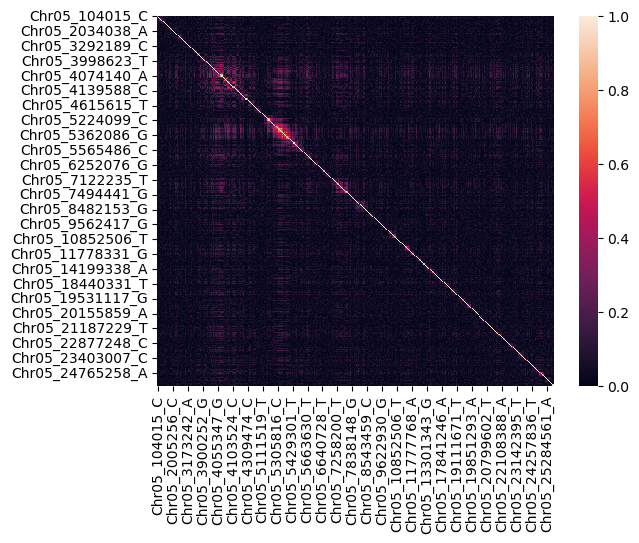

In [57]:
sns.heatmap(tmin_cor)

In [58]:
#Find 10 features with high correlation with the highest beta
tmin_sub_columns = ["Chr05_21787000_A", "Chr05_21781161_C", "Chr05_4720212_T",
 "Chr05_4058608_T" ,"Chr05_21757735_A", "Chr05_4045999_A",
 "Chr05_25313101_T", "Chr05_4071411_C", "Chr05_22108388_A",
 "Chr05_4049332_G", "Chr05_24866644_G"]
tmin_sub = np.abs(X[tmin_sub_columns].corr())
tmin_sub

,Chr05_21787000_A,Chr05_21781161_C,Chr05_4720212_T,Chr05_4058608_T,Chr05_21757735_A,Chr05_4045999_A,Chr05_25313101_T,Chr05_4071411_C,Chr05_22108388_A,Chr05_4049332_G,Chr05_24866644_G
Chr05_21787000_A,1.000000,0.359160,0.221243,0.194146,0.193334,0.178434,0.170383,0.167927,0.167010,0.164096,0.163416
Chr05_21781161_C,0.359160,1.000000,0.116593,0.156573,0.038172,0.168768,0.117000,0.195668,0.090086,0.113589,0.107964
Chr05_4720212_T,0.221243,0.116593,1.000000,0.100309,0.002032,0.051333,0.078307,0.144425,0.124359,0.026058,0.089384
Chr05_4058608_T,0.194146,0.156573,0.100309,1.000000,0.010008,0.445923,0.207089,0.560483,0.147299,0.427092,0.097687
Chr05_21757735_A,0.193334,0.038172,0.002032,0.010008,1.000000,0.045730,0.075299,0.015277,0.009471,0.035696,0.003356
Chr05_4045999_A,0.178434,0.168768,0.051333,0.445923,0.045730,1.000000,0.174558,0.442333,0.163603,0.453525,0.070351
Chr05_25313101_T,0.170383,0.117000,0.078307,0.207089,0.075299,0.174558,1.000000,0.195655,0.149685,0.117369,0.078786
Chr05_4071411_C,0.167927,0.195668,0.144425,0.560483,0.015277,0.442333,0.195655,1.000000,0.196422,0.277690,0.098948
Chr05_22108388_A,0.167010,0.090086,0.124359,0.147299,0.009471,0.163603,0.149685,0.196422,1.000000,0.098217,0.135013
Chr05_4049332_G,0.164096,0.113589,0.026058,0.427092,0.035696,0.453525,0.117369,0.277690,0.098217,1.000000,0.003676


<Axes: >

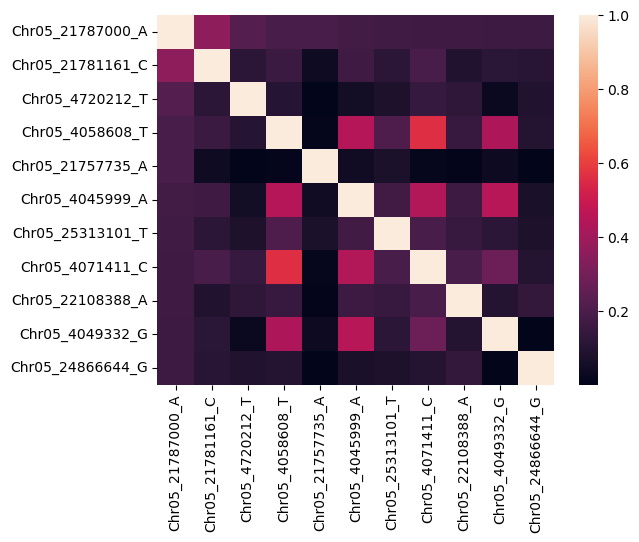

In [59]:
sns.heatmap(tmin_sub)

<Axes: >

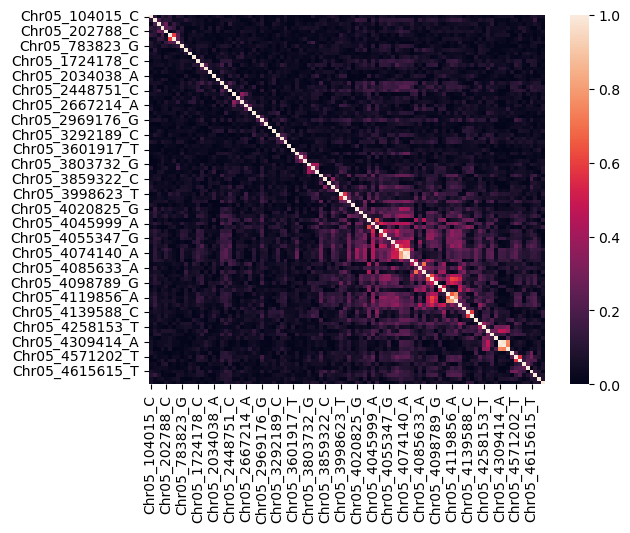

In [60]:
sns.heatmap(tmin_cor.iloc[:100, :100])

#### Results
The "Chr05_21787000_A" is associated with minimum annual temperature.
"Chr05_21781161_C" has the highest correlation with "Chr05_21787000_A".

Variant: "Chr05_21787000_A" Subgroups of Variants: "Chr05_21787000_A" and
"Chr05_21781161_C"

## Fit Average Cloud Density

In [61]:
y_cloud = cloud_dens_orig[2]

In [62]:
X_cloud = trans_X[~y_cloud.isna()]
y_cloud = y_cloud[~y_cloud.isna()]

In [63]:
X_cloud.shape, y_cloud.shape

((869, 5114), (869,))

In [64]:
X_train_cloud, X_test_cloud, y_train_cloud, y_test_cloud = train_test_split(X_cloud, y_cloud, test_size=0.2, random_state=1234) #test_size
X_train_cloud, X_valid_cloud, y_train_cloud, y_valid_cloud = train_test_split(X_train_cloud, y_train_cloud, test_size=0.2, random_state=331) #20% of X-tranin


In [65]:
# training = 64%, validation = 16%, test = 20%
X_train_cloud.shape, y_train_cloud.shape, X_valid_cloud.shape, y_valid_cloud.shape, X_test_cloud.shape, y_test_cloud.shape


((556, 5114), (556,), (139, 5114), (139,), (174, 5114), (174,))

In [66]:
imputer = SimpleImputer(strategy="most_frequent")
pipe = Pipeline(steps=[("impute", imputer), ("rf", RandomForestRegressor())])
pipe.fit(X_train_cloud, y_train_cloud)

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('rf', RandomForestRegressor())])

In [67]:
#analysis RF
ypred_valid_cloud = pipe.predict(X_valid_cloud)
MSE_cloud = mean_squared_error(y_valid_cloud, ypred_valid_cloud)
r2_score_cloud = r2_score(y_valid_cloud, ypred_valid_cloud)
score_cloud = pipe.score(X_valid_cloud, y_valid_cloud)
MAE_cloud = mean_absolute_error(ypred_valid_cloud, y_valid_cloud)

d = {'Score': score_cloud,  'R^2': r2_score_cloud, 'MSE': MSE_cloud, 'MAE': MAE_cloud}
pd.DataFrame(data=d, index=[1])

,Score,R^2,MSE,MAE
1,0.357808,0.357808,0.756745,0.58411


### Try more models

In [68]:
imputers = {
    "simple_imputer": SimpleImputer(strategy="most_frequent"),
    "knn_imputer": KNNImputer()
}
models = {
    "rf": RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
    "lasso": Lasso(),
    "Ridge": Ridge()

}
pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe
pipes

{'simple_imputer+rf': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'simple_imputer+lasso': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('lasso', Lasso())]),
 'simple_imputer+Ridge': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('Ridge', Ridge())]),
 'knn_imputer+rf': Pipeline(steps=[('knn_imputer', KNNImputer()),
                 ('rf', RandomForestRegressor(min_samples_leaf=5))]),
 'knn_imputer+lasso': Pipeline(steps=[('knn_imputer', KNNImputer()), ('lasso', Lasso())]),
 'knn_imputer+Ridge': Pipeline(steps=[('knn_imputer', KNNImputer()), ('Ridge', Ridge())])}

In [69]:
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X_train_cloud, y_train_cloud )

simple_imputer+rf
simple_imputer+lasso
simple_imputer+Ridge
knn_imputer+rf
knn_imputer+lasso
knn_imputer+Ridge


In [70]:
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    # can also tune parameters in the imputation step
    "knn_imputer__n_neighbors": [2, 5, 10],
    "ridge__lambda":np.logspace(-3, 7, 10)
}
# fit the model, compute error and y hat
valid_errs_cloud = {}
tuned_pipelines_cloud = {}
ypred_valid_cloud = {}

for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys()if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search_cloud = GridSearchCV(pipe, cv_param_grid)
    pipe_search_cloud.fit(X_train_cloud, y_train_cloud)
    valid_errs_cloud[pipe_name] = pipe_search_cloud.score(X_valid_cloud, y_valid_cloud)
    tuned_pipelines_cloud[pipe_name] = copy.deepcopy(pipe_search_cloud)
    ypred_valid_cloud[pipe_name] = pipe.predict(X_valid_cloud)
                                                          
valid_errs_cloud

simple_imputer+rf
simple_imputer+lasso
simple_imputer+Ridge
knn_imputer+rf
knn_imputer+lasso
knn_imputer+Ridge


{'simple_imputer+rf': 0.3625980883405323,
 'simple_imputer+lasso': 0.5865573756629916,
 'simple_imputer+Ridge': 0.66345476337736,
 'knn_imputer+rf': 0.3518763980656924,
 'knn_imputer+lasso': 0.5865573756629916,
 'knn_imputer+Ridge': 0.66345476337736}

In [71]:
ypred_valid_cloud = pd.DataFrame.from_dict(ypred_valid_cloud)
ypred_valid_cloud

,simple_imputer+rf,simple_imputer+lasso,simple_imputer+Ridge,knn_imputer+rf,knn_imputer+lasso,knn_imputer+Ridge
0,0.449618,-0.006224,1.000006,0.449618,-0.006224,1.000006
1,-0.311225,-0.006224,-0.647461,-0.311225,-0.006224,-0.647461
2,0.513286,-0.006224,0.121730,0.513286,-0.006224,0.121730
3,-0.781172,-0.006224,-1.045531,-0.781172,-0.006224,-1.045531
4,-0.474883,-0.006224,-0.806663,-0.474883,-0.006224,-0.806663
...,...,...,...,...,...,...
134,0.321780,-0.006224,0.755891,0.321780,-0.006224,0.755891
135,0.654096,-0.006224,0.829754,0.654096,-0.006224,0.829754
136,-0.472865,-0.006224,-0.603269,-0.472865,-0.006224,-0.603269
137,0.017602,-0.006224,0.192862,0.017602,-0.006224,0.192862


In [72]:
cloud_summary = pd.DataFrame.from_dict(valid_errs_cloud,
                                       columns = ["Valid Errors"],
                                       orient='index')

In [73]:
# compute MSE and MAE
MSE_cloud = []
for i in range(6):
    column_name = ypred_valid_cloud.columns[i]
    MSE = mean_squared_error(y_valid_cloud, ypred_valid_cloud[column_name].to_numpy())
    MSE_cloud.append(MSE)

MAE_cloud = []
for i in range(6):
    column_name = ypred_valid_cloud.columns[i]
    MAE = mean_absolute_error(y_valid_cloud, ypred_valid_cloud[column_name].to_numpy())
    MAE_cloud.append(MAE)

cloud_summary["MSE"] = MSE_cloud
cloud_summary["MAE"] = MAE_cloud
cloud_summary


,Valid Errors,MSE,MAE
simple_imputer+rf,0.362598,0.754273,0.583870
simple_imputer+lasso,0.586557,1.178442,0.867295
simple_imputer+Ridge,0.663455,0.396577,0.439430
knn_imputer+rf,0.351876,0.754273,0.583870
knn_imputer+lasso,0.586557,1.178442,0.867295
knn_imputer+Ridge,0.663455,0.396577,0.439430


In [74]:
tuned_pipelines['simple_imputer+rf'].score(X_test_cloud, y_test_cloud)

-0.19880826908956362

In [75]:
tuned_pipelines['simple_imputer+lasso'].score(X_test_cloud, y_test_cloud)

-0.29399257573073134

In [76]:
tuned_pipelines['simple_imputer+Ridge'].score(X_test_cloud, y_test_cloud)

-0.39171850643502903

In [77]:
tuned_pipelines['knn_imputer+rf'].score(X_test_cloud, y_test_cloud)

-0.19033705222180686

In [78]:
tuned_pipelines['knn_imputer+lasso'].score(X_test_cloud, y_test_cloud)

-0.29399257573073134

In [79]:
tuned_pipelines['knn_imputer+Ridge'].score(X_test_cloud, y_test_cloud)

-0.39171850643502903

In [80]:
#find the best estimator
pipe_search.best_estimator_

Pipeline(steps=[('knn_imputer', KNNImputer(n_neighbors=2)), ('Ridge', Ridge())])

##### The best model is  knn_imputer + Ridge/simple_imputer + Ridge. We will use knn_imputer + Ridge to fit test set here.

In [81]:
pipe_search.best_estimator_.named_steps["knn_imputer"]

KNNImputer(n_neighbors=2)

In [82]:
pipe_search.best_estimator_.named_steps["Ridge"].coef_

array([ 8.40710469e-04, -7.10298514e-05, -2.81723692e-04, ...,
       -9.83876046e-04,  1.39245584e-03,  2.37963877e-03])

In [83]:
#fit test to the best estimator
imputers = {
    "knn_imputer": KNNImputer()
}
models = {
    "Ridge": Ridge()
}
pipes = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_name = imputer_name + "+" + model_name
        pipes[pipe_name] = pipe
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    pipe.fit(X_test_cloud, y_test_cloud)
cv_param_grid_all = {
    "knn_imputer__n_neighbors": [2],
    "ridge__lambda":np.logspace(-3, 7, 10)
}

knn_imputer+Ridge


In [84]:
test_errs_cloud = {}
ypred_test_cloud = {}
MSE = {}
for pipe_name, pipe in pipes.items():
    print(pipe_name)
    # get relevant CV parameters given the steps of the pipeline
    cv_param_grid = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    # run CV for pipeline
    pipe_search_cloud = GridSearchCV(pipe, cv_param_grid)
    pipe_search_cloud.fit(X_train_cloud, y_train_cloud)
    test_errs_cloud[pipe_name] = pipe_search_cloud.score(X_test_cloud, y_test_cloud)
    ypred_test_cloud[pipe_name] = pipe.predict(X_test_cloud)
test_errs_cloud


knn_imputer+Ridge


{'knn_imputer+Ridge': 0.6329266748498016}

In [85]:
 ypred_test_cloud

{'knn_imputer+Ridge': array([ 0.59487663,  0.62016663,  0.15177861,  0.15202578, -0.02494379,
        -0.92974354, -0.68959393, -0.02504799, -1.08084456,  0.03118697,
         0.97760896, -0.22109096, -0.02494939,  0.27622057, -0.53171732,
         0.15201713,  1.46589018, -0.92963825,  1.29711717, -0.02502044,
         0.69296122,  0.15187991,  0.69308779,  0.9776474 , -0.00429247,
        -0.76168839, -0.6896375 , -1.26964448, -0.72852532, -0.57300254,
         0.08219888, -0.24814749, -0.72843843,  2.88367621, -0.92974195,
         0.62015432,  0.69747826,  0.69736585,  0.15198061, -0.61695769,
         0.3988669 ,  0.24028776,  0.62007882, -0.00426111,  1.77077576,
         0.03112493,  0.62011489, -0.48457557, -0.92970648,  1.56529675,
        -0.48461359, -0.48457283,  1.39118366,  0.81350869,  0.15192465,
         1.67746721, -1.0442647 , -0.72845493,  0.70186372,  0.36473887,
        -1.2234746 ,  0.83677587, -0.53167614,  0.61210935, -0.76167747,
        -0.48454711, -0.864660

In [86]:
ypred_test_cloud = [0.59487663,  0.62016663,  0.15177861,  0.15202578, -0.02494379,
        -0.92974354, -0.68959393, -0.02504799, -1.08084456,  0.03118697,
         0.97760896, -0.22109096, -0.02494939,  0.27622057, -0.53171732,
         0.15201713,  1.46589018, -0.92963825,  1.29711717, -0.02502044,
         0.69296122,  0.15187991,  0.69308779,  0.9776474 , -0.00429247,
        -0.76168839, -0.6896375 , -1.26964448, -0.72852532, -0.57300254,
         0.08219888, -0.24814749, -0.72843843,  2.88367621, -0.92974195,
         0.62015432,  0.69747826,  0.69736585,  0.15198061, -0.61695769,
         0.3988669 ,  0.24028776,  0.62007882, -0.00426111,  1.77077576,
         0.03112493,  0.62011489, -0.48457557, -0.92970648,  1.56529675,
        -0.48461359, -0.48457283,  1.39118366,  0.81350869,  0.15192465,
         1.67746721, -1.0442647 , -0.72845493,  0.70186372,  0.36473887,
        -1.2234746 ,  0.83677587, -0.53167614,  0.61210935, -0.76167747,
        -0.48454711, -0.8646603 ,  0.6929575 , -0.02509346, -0.85287498,
         0.36483915,  0.97755184, -0.48451091, -0.02503688, -0.9178715 ,
         0.35987361, -0.87644792, -0.02503754, -0.94159743, -0.13787599,
        -0.02491726, -0.48460944, -0.92969907,  0.62007829, -0.61694126,
        -0.92974342, -1.26950605,  1.2531549 ,  0.62027136,  0.14907533,
         1.30296489, -0.68964341,  0.62010746, -0.48459031, -0.85301784,
        -0.48466894, -0.48450917, -0.65244439, -0.72839751, -1.81268259,
        -0.92981005,  0.69311302,  0.62020924, -0.86472086, -2.18550206,
         0.15181999,  0.69739447, -0.65236173, -0.85291441, -1.22830509,
        -0.7283299 ,  0.69314964, -0.66584045, -2.18565092,  0.15188118,
         0.69746619,  0.69294789, -0.91782627,  0.42407536,  0.03106164,
        -0.61689705,  0.36490633, -0.85310748, -0.92969613, -1.08078985,
         0.69739123,  1.30567897,  0.15192687,  0.62021947,  1.13637791,
        -0.48457311,  0.69297703, -0.6170397 ,  0.1519779 ,  0.72738999,
         1.03458226,  0.62008869, -0.91775064, -0.02495457,  1.03457014,
         0.69314778, -0.92978044, -0.70770706,  0.69737206,  0.83688059,
        -0.28579975, -1.81278684, -0.02503899, -0.48461987, -0.72852204,
        -0.09092206,  0.69306984,  0.69308568,  0.62015087,  0.62016307,
         0.62013477, -0.48453186, -0.65217267, -0.85301644, -0.92964095,
         4.24705597,  1.39111648, -0.02499386,  0.6201805 ,  0.61222892,
         0.62022966, -1.26958838,  0.9995463 ,  1.42808799, -0.6523674 ,
         0.62017647,  0.62011569, -0.72840093,  2.24844786]

In [87]:
# compute loss function
cloud_summary = pd.DataFrame.from_dict(test_errs_cloud,
                                       columns = ["Errors"],
                                       orient = "index")
cloud_summary["MSE"] = mean_squared_error(y_test_cloud, ypred_test_cloud)
cloud_summary["MAE"] = mean_absolute_error(y_test_cloud, ypred_test_cloud)
cloud_summary

,Errors,MSE,MAE
knn_imputer+Ridge,0.632927,5.658016e-08,0.000168


In [88]:
max(abs(pipe_search_cloud.best_estimator_.named_steps["Ridge"].coef_))

0.015604843101773567

In [89]:
# find the highest beta
cloud_bate_est = abs(pipe_search_cloud.best_estimator_.named_steps["Ridge"].coef_)
var_col = X_test_cloud.columns
bate_est = pd.DataFrame([cloud_bate_est], columns = [var_col])
cloud_beta = var_col[np.argmax(bate_est)]
cloud_beta

'Chr06_6396240_T'

In [90]:
# Pull Chr06 goup out.
Chr06 = snp_columns_df.loc[snp_columns_df['CHR'] == "Chr06"]
Chr06

,CHR,number,CGAT
1962,Chr06,414059,G
1963,Chr06,451294,G
1964,Chr06,610899,C
1965,Chr06,660215,C
1966,Chr06,745207,G
...,...,...,...
2347,Chr06,27671983,A
2348,Chr06,27675959,G
2349,Chr06,27676639,C
2350,Chr06,27678363,G


In [91]:
# check the location of beta
Chr06_6396240_T = Chr06.loc[Chr06['number'] == "6396240"]
Chr06_6396240_T

,CHR,number,CGAT
2055,Chr06,6396240,T


In [92]:
# make a correlation table for all Chr05 in selected X
cloud_cor = np.abs(selected_X.iloc[:, 1962:2352].corr())
cloud_cor

,Chr06_414059_G,Chr06_451294_G,Chr06_610899_C,Chr06_660215_C,Chr06_745207_G,Chr06_1020180_G,Chr06_1104928_G,Chr06_1169135_G,Chr06_1184189_A,Chr06_1518627_T,...,Chr06_27617632_A,Chr06_27630007_A,Chr06_27633596_C,Chr06_27634026_T,Chr06_27653477_T,Chr06_27671983_A,Chr06_27675959_G,Chr06_27676639_C,Chr06_27678363_G,Chr06_27745238_A
Chr06_414059_G,1.000000,0.246242,0.106870,0.083680,0.175217,0.117029,0.033573,0.054614,0.037702,0.020180,...,0.103951,0.029219,0.073962,0.076665,0.076976,0.060590,0.033384,0.053539,0.112201,0.061194
Chr06_451294_G,0.246242,1.000000,0.010092,0.180868,0.103594,0.090194,0.081786,0.010207,0.064140,0.076684,...,0.067099,0.066181,0.109572,0.064279,0.011322,0.099105,0.058848,0.087531,0.090926,0.036903
Chr06_610899_C,0.106870,0.010092,1.000000,0.098756,0.197056,0.017123,0.075959,0.029607,0.018696,0.018253,...,0.067287,0.008071,0.069594,0.059671,0.043006,0.047607,0.032745,0.030230,0.043057,0.109244
Chr06_660215_C,0.083680,0.180868,0.098756,1.000000,0.163137,0.093979,0.056563,0.068415,0.052941,0.074700,...,0.085378,0.018604,0.099839,0.082681,0.086949,0.112038,0.053686,0.047739,0.053225,0.063791
Chr06_745207_G,0.175217,0.103594,0.197056,0.163137,1.000000,0.015667,0.014536,0.043899,0.055691,0.105332,...,0.030293,0.055146,0.018010,0.019646,0.055336,0.075907,0.040437,0.006157,0.009638,0.010242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chr06_27671983_A,0.060590,0.099105,0.047607,0.112038,0.075907,0.064175,0.159902,0.048402,0.069544,0.013734,...,0.321230,0.225621,0.140539,0.386263,0.547535,1.000000,0.515708,0.616604,0.398582,0.237714
Chr06_27675959_G,0.033384,0.058848,0.032745,0.053686,0.040437,0.036573,0.112362,0.030745,0.055554,0.069525,...,0.463314,0.409942,0.085677,0.414173,0.591979,0.515708,1.000000,0.688480,0.514791,0.205586
Chr06_27676639_C,0.053539,0.087531,0.030230,0.047739,0.006157,0.071126,0.153778,0.079256,0.084325,0.018256,...,0.373077,0.266087,0.161269,0.416694,0.578086,0.616604,0.688480,1.000000,0.563720,0.243601
Chr06_27678363_G,0.112201,0.090926,0.043057,0.053225,0.009638,0.085183,0.108360,0.015841,0.075331,0.011456,...,0.516241,0.405456,0.192905,0.410107,0.488235,0.398582,0.514791,0.563720,1.000000,0.198836


<Axes: >

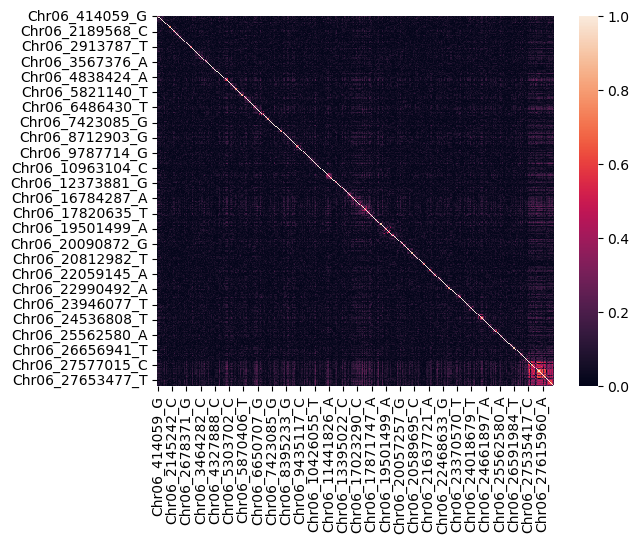

In [93]:
sns.heatmap(cloud_cor)

In [94]:
Chr06_6396240_T_corr = cloud_cor.iloc[93].to_frame()
Chr06_6396240_T_corr.sort_values(by=['Chr06_6396240_T'], ascending=False).head(11)

,Chr06_6396240_T
Chr06_6396240_T,1.000000
Chr06_6121717_G,0.184730
Chr06_17157024_A,0.144531
Chr06_20662115_C,0.121347
Chr06_6048543_A,0.117065
Chr06_6443638_T,0.116921
Chr06_5519729_C,0.115027
Chr06_27634026_T,0.114321
Chr06_6390305_A,0.113085
Chr06_20230326_T,0.111230


In [95]:
cloud_sub_columns = ["Chr06_6396240_T", "Chr06_6121717_G", "Chr06_17157024_A",
                     "Chr06_20662115_C" ,"Chr06_6048543_A", "Chr06_6443638_T",
                     "Chr06_5519729_C", "Chr06_27634026_T", "Chr06_6390305_A",
                     "Chr06_20230326_T", "Chr06_24661897_A"]
cloud_sub = np.abs(X[cloud_sub_columns].corr())
cloud_sub

,Chr06_6396240_T,Chr06_6121717_G,Chr06_17157024_A,Chr06_20662115_C,Chr06_6048543_A,Chr06_6443638_T,Chr06_5519729_C,Chr06_27634026_T,Chr06_6390305_A,Chr06_20230326_T,Chr06_24661897_A
Chr06_6396240_T,1.000000,0.184730,0.144531,0.121347,0.117065,0.116921,0.115027,0.114321,0.113085,0.111230,0.110722
Chr06_6121717_G,0.184730,1.000000,0.111403,0.061304,0.363151,0.044002,0.015088,0.119108,0.019460,0.128376,0.087044
Chr06_17157024_A,0.144531,0.111403,1.000000,0.040558,0.074272,0.083735,0.021819,0.123865,0.020520,0.154059,0.049033
Chr06_20662115_C,0.121347,0.061304,0.040558,1.000000,0.015059,0.112501,0.087724,0.101250,0.023770,0.078045,0.047871
Chr06_6048543_A,0.117065,0.363151,0.074272,0.015059,1.000000,0.044121,0.030902,0.142024,0.021514,0.060441,0.050280
Chr06_6443638_T,0.116921,0.044002,0.083735,0.112501,0.044121,1.000000,0.020145,0.095188,0.120066,0.121475,0.033922
Chr06_5519729_C,0.115027,0.015088,0.021819,0.087724,0.030902,0.020145,1.000000,0.052318,0.039719,0.010813,0.024750
Chr06_27634026_T,0.114321,0.119108,0.123865,0.101250,0.142024,0.095188,0.052318,1.000000,0.029240,0.138807,0.043206
Chr06_6390305_A,0.113085,0.019460,0.020520,0.023770,0.021514,0.120066,0.039719,0.029240,1.000000,0.001948,0.005412
Chr06_20230326_T,0.111230,0.128376,0.154059,0.078045,0.060441,0.121475,0.010813,0.138807,0.001948,1.000000,0.067085


<Axes: >

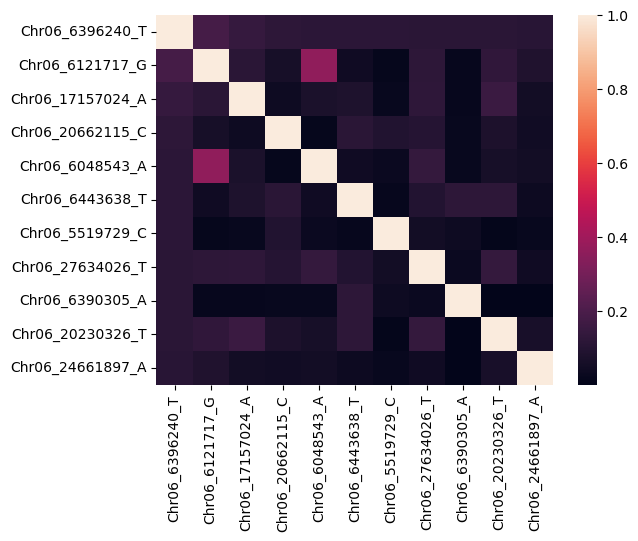

In [96]:
sns.heatmap(cloud_sub)

#### Result
he most important variant, which is associated with average cloud density, is
Chr06_6396240_T. There exist some variants in selected X that have correlation with the
highest beta Chr06_6396240_T, which are "Chr06_6121717_G", "Chr06_6396240_T".